# Informer Demo

## Download code and dataset

In [1]:
!git clone https://github.com/zhouhaoyi/Informer2020.git
!git clone https://github.com/zhouhaoyi/ETDataset.git
!ls

Cloning into 'Informer2020'...
remote: Enumerating objects: 576, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 576 (delta 0), reused 2 (delta 0), pack-reused 573
Receiving objects: 100% (576/576), 6.49 MiB | 11.90 MiB/s, done.
Resolving deltas: 100% (328/328), done.
Cloning into 'ETDataset'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 187 (delta 25), reused 20 (delta 20), pack-reused 159
Receiving objects: 100% (187/187), 3.86 MiB | 13.03 MiB/s, done.
Resolving deltas: 100% (62/62), done.
ETDataset  Informer2020  sample_data


In [38]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

In [29]:
!pip install -r ./Informer2020/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.8/37.8 MB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 15.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 55.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 67.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement torch==1.8.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1)
ERROR: No matching distribution found for torch==1.8.0


## Experiments: Train and Test

In [81]:
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch

In [82]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = './' # root path of data file
args.data_path = 'trial2.csv' # data file
args.features = 'MS' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'Therapist position x' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 24 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 9 # encoder input size
args.dec_in = 9 # decoder input size
args.c_out = 1 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'fixed' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 50
args.patience = 50
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'


In [83]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

In [84]:
# Set augments by using data name
data_parser = {
    'ETTh1':{'data':'ETTh1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTh2':{'data':'ETTh2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm1':{'data':'ETTm1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm2':{'data':'ETTm2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'sp500':{'data':'sp500.csv','T':'OT','M':[5,5,5],'S':[1,1,1],'MS':[5,5,1]},
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

In [85]:
args.detail_freq = args.freq
args.freq = args.freq[-1:]

In [86]:
print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informer', 'data': 'custom', 'root_path': './', 'data_path': 'trial2.csv', 'features': 'MS', 'target': 'Therapist position x', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 24, 'enc_in': 9, 'dec_in': 9, 'c_out': 1, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'fixed', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 50, 'patience': 50, 'des': 'exp', 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 'h'}


In [87]:
Exp = Exp_Informer

In [88]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_custom_ftMS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebfixed_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 1205
val 167
test 355
Epoch: 1 cost time: 3.0271315574645996
Epoch: 1, Steps: 37 | Train Loss: 0.3396236 Vali Loss: 1.4953008 Test Loss: 1.1348792
Validation loss decreased (inf --> 1.495301).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 2.980266809463501
Epoch: 2, Steps: 37 | Train Loss: 0.0805160 Vali Loss: 0.6605511 Test Loss: 1.2106370
Validation loss decreased (1.495301 --> 0.660551).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3 cost time: 3.00956654548645
Epoch: 3, Steps: 37 | Train Loss: 0.0392767 Vali Loss: 0.4415664 Test Loss: 1.0476437
Validation loss decreased (0.660551 --> 0.441566).  Saving model ...
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 3.0010108947753906
Epoch: 4, Steps: 37 | Train Loss: 0.0320568 Vali Loss: 0.5098397 Test Loss: 1.0922378
EarlySto

## Prediction

In [89]:
import os

# set saved model path
setting = 'informer_custom_ftMS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebfixed_dtTrue_mxTrue_exp_0'
# path = os.path.join(args.checkpoints,setting,'checkpoint.pth')

In [90]:
# If you already have a trained model, you can set the arguments and model path, then initialize a Experiment and use it to predict
# Prediction is a sequence which is adjacent to the last date of the data, and does not exist in the data
# If you want to get more information about prediction, you can refer to code `exp/exp_informer.py function predict()` and `data/data_loader.py class Dataset_Pred`

exp = Exp(args)

exp.predict(setting, True)

Use GPU: cuda:0
pred 1


In [91]:
# the prediction will be saved in ./results/{setting}/real_prediction.npy
import numpy as np

prediction = np.load('./results/'+setting+'/real_prediction.npy')

prediction.shape

(1, 24, 1)

### More details about Prediction - prediction function

In [92]:
# here is the detailed code of function predict

def predict(exp, setting, load=False):
    pred_data, pred_loader = exp._get_data(flag='pred')
        
    if load:
        path = os.path.join(exp.args.checkpoints, setting)
        best_model_path = path+'/'+'checkpoint.pth'
        exp.model.load_state_dict(torch.load(best_model_path))

    exp.model.eval()
        
    preds = []
        
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(pred_loader):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        # decoder input
        if exp.args.padding==0:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        elif exp.args.padding==1:
            dec_inp = torch.ones([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        else:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:exp.args.label_len,:], dec_inp], dim=1).float().to(exp.device)
        # encoder - decoder
        if exp.args.use_amp:
            with torch.cuda.amp.autocast():
                if exp.args.output_attention:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        else:
            if exp.args.output_attention:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
            else:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        f_dim = -1 if exp.args.features=='MS' else 0
        batch_y = batch_y[:,-exp.args.pred_len:,f_dim:].to(exp.device)
        
        pred = outputs.detach().cpu().numpy()#.squeeze()
        
        preds.append(pred)

    preds = np.array(preds)
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
    
    # result save
    folder_path = './results/' + setting +'/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    np.save(folder_path+'real_prediction.npy', preds)
    
    return preds


In [93]:
# you can also use this prediction function to get result
prediction = predict(exp, setting, True)

pred 1


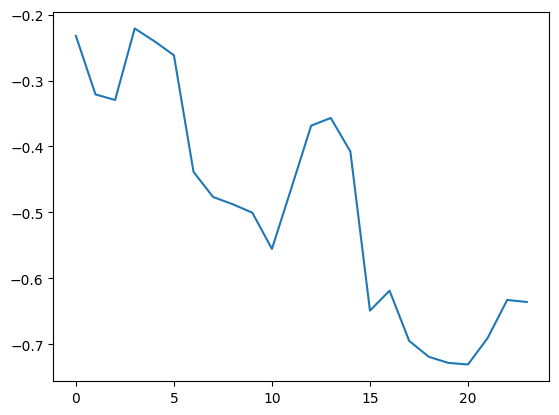

In [94]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(prediction[0,:,-1])
plt.show()

### More details about Prediction - prediction dataset

You can give a `root_path` and `data_path` of the data you want to forecast, and set `seq_len`, `label_len`, `pred_len` and other arguments as other Dataset. The difference is that you can set a more detailed freq such as `15min` or `3h` to generate the timestamp of prediction series.

`Dataset_Pred` only has one sample (including `encoder_input: [1, seq_len, dim]`, `decoder_token: [1, label_len, dim]`, `encoder_input_timestamp: [1, seq_len, date_dim]`, `decoder_input_timstamp: [1, label_len+pred_len, date_dim]`). It will intercept the last sequence of the given data (seq_len data) to forecast the unseen future sequence (pred_len data).

In [95]:
from data.data_loader import Dataset_Pred
from torch.utils.data import DataLoader

In [96]:
Data = Dataset_Pred
timeenc = 0 if args.embed!='timeF' else 1
flag = 'pred'; shuffle_flag = False; drop_last = False; batch_size = 1

freq = args.detail_freq

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    timeenc=timeenc,
    freq=freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [97]:
len(data_set), len(data_loader)

(1, 1)

## Visualization

In [98]:
# When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
# The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)

preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape

((352, 24, 1), (352, 24, 1))

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

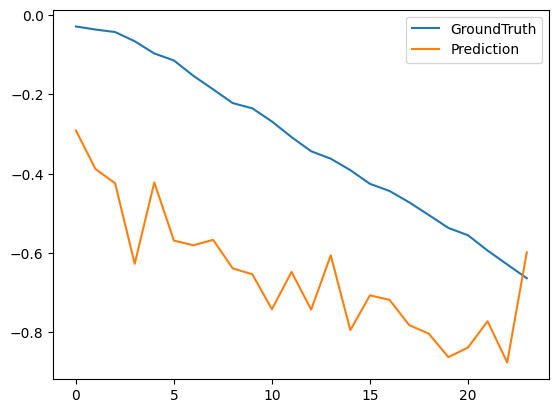

In [100]:
# draw OT prediction
plt.figure()
plt.plot(trues[0,:,-1], label='GroundTruth')
plt.plot(preds[0,:,-1], label='Prediction')
plt.legend()
plt.show()

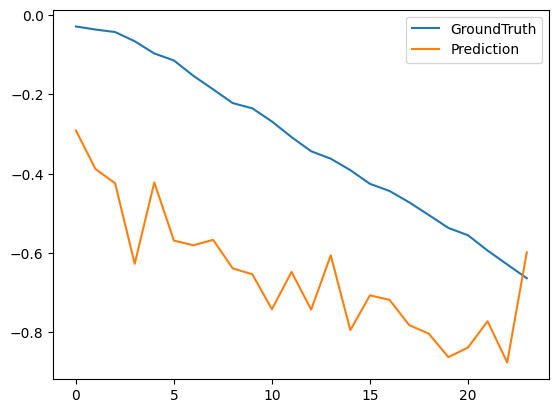

In [101]:
# draw HUFL prediction
plt.figure()
plt.plot(trues[0,:,0], label='GroundTruth')
plt.plot(preds[0,:,0], label='Prediction')
plt.legend()
plt.show()

In [78]:
from data.data_loader import Dataset_ETT_hour
from torch.utils.data import DataLoader

Data = Dataset_ETT_hour
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'; shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    freq=args.freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [102]:
import os

args.output_attention = True

exp = Exp(args)

model = exp.model

setting = 'informer_custom_ftMS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebfixed_dtTrue_mxTrue_exp_0'
path = os.path.join(args.checkpoints,setting,'checkpoint.pth')
model.load_state_dict(torch.load(path))

Use GPU: cuda:0


<All keys matched successfully>

In [103]:
# attention visualization
idx = 0
for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
    if i!=idx:
        continue
    batch_x = batch_x.float().to(exp.device)
    batch_y = batch_y.float()

    batch_x_mark = batch_x_mark.float().to(exp.device)
    batch_y_mark = batch_y_mark.float().to(exp.device)
    
    dec_inp = torch.zeros_like(batch_y[:,-args.pred_len:,:]).float()
    dec_inp = torch.cat([batch_y[:,:args.label_len,:], dec_inp], dim=1).float().to(exp.device)
    
    outputs,attn = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

In [104]:
attn[0].shape, attn[1].shape #, attn[2].shape

(torch.Size([1, 8, 96, 96]), torch.Size([1, 8, 48, 48]))

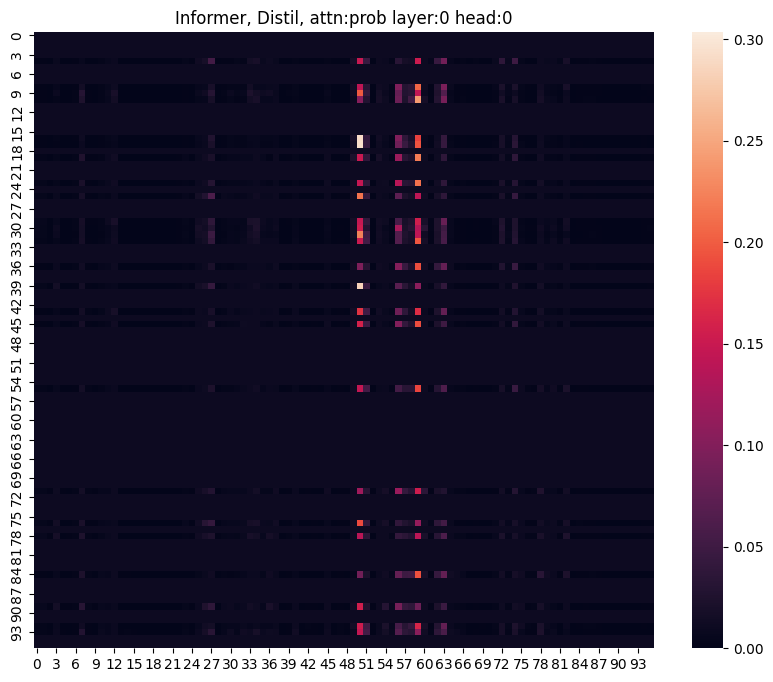

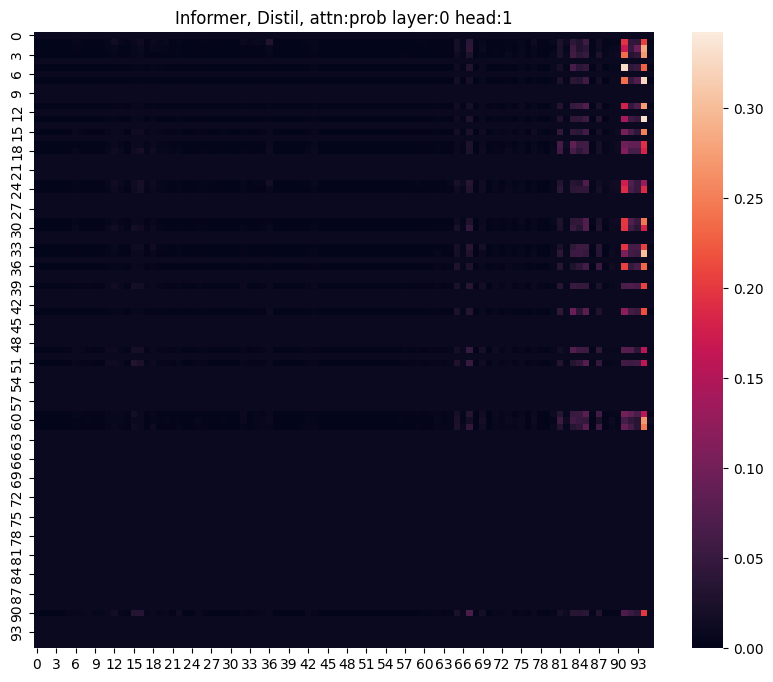

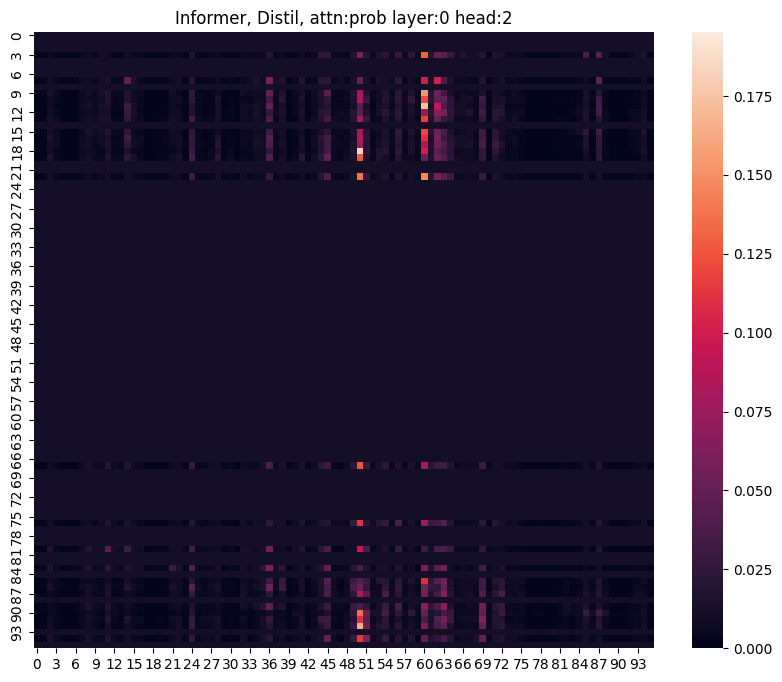

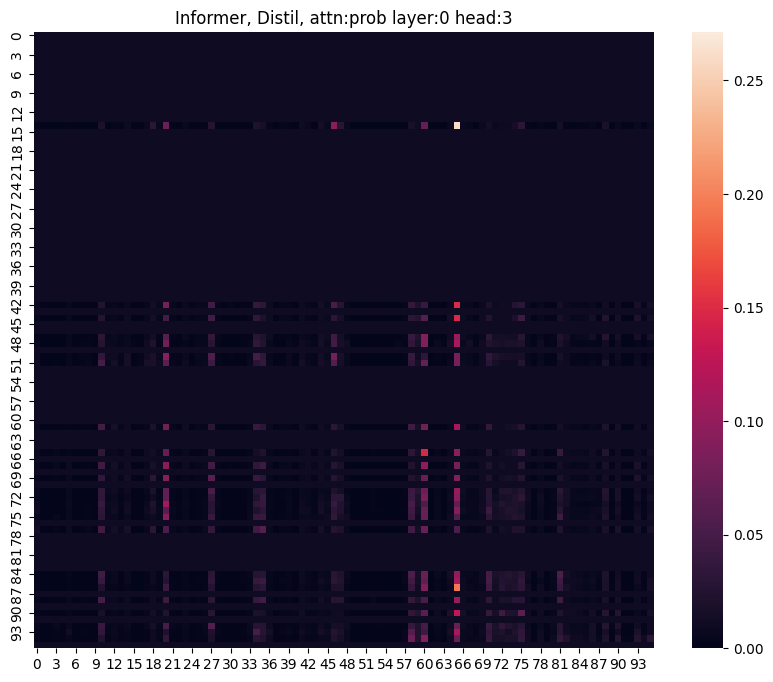

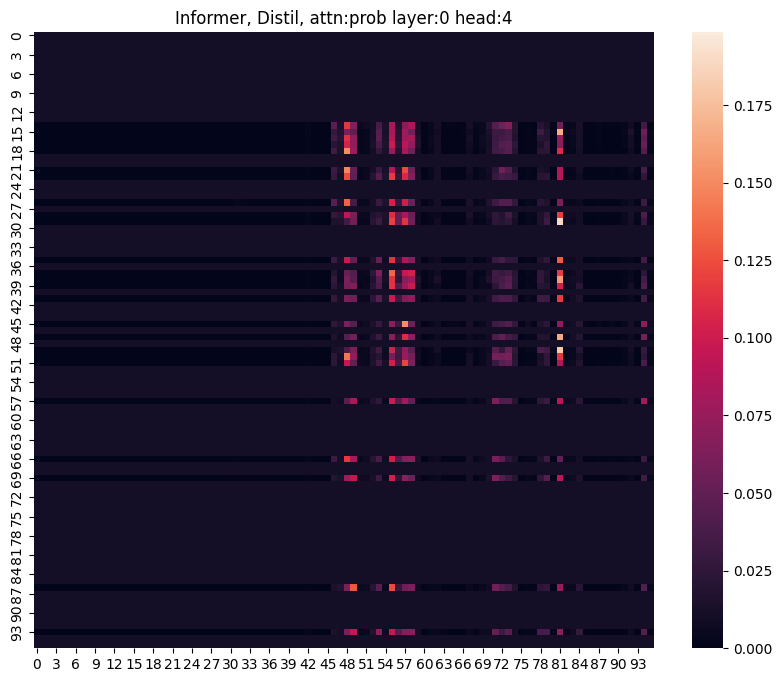

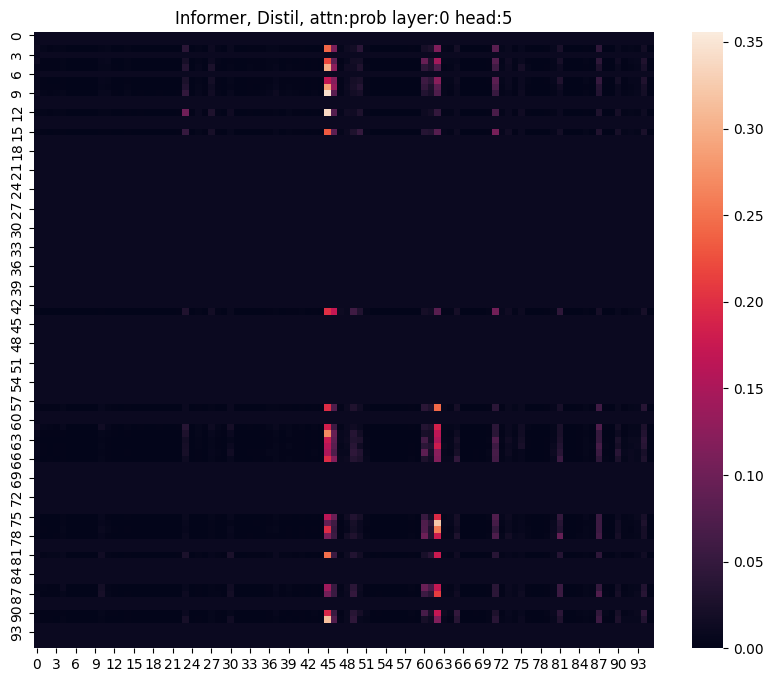

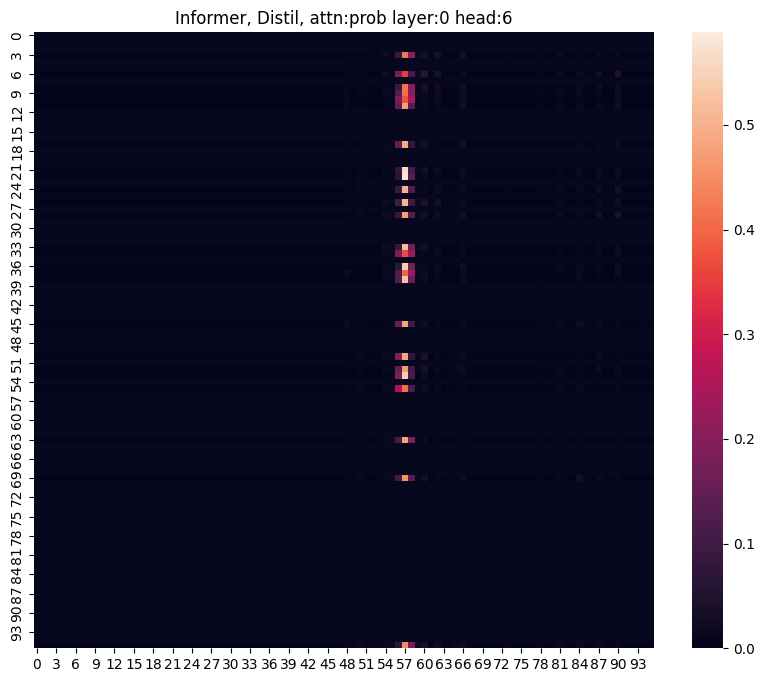

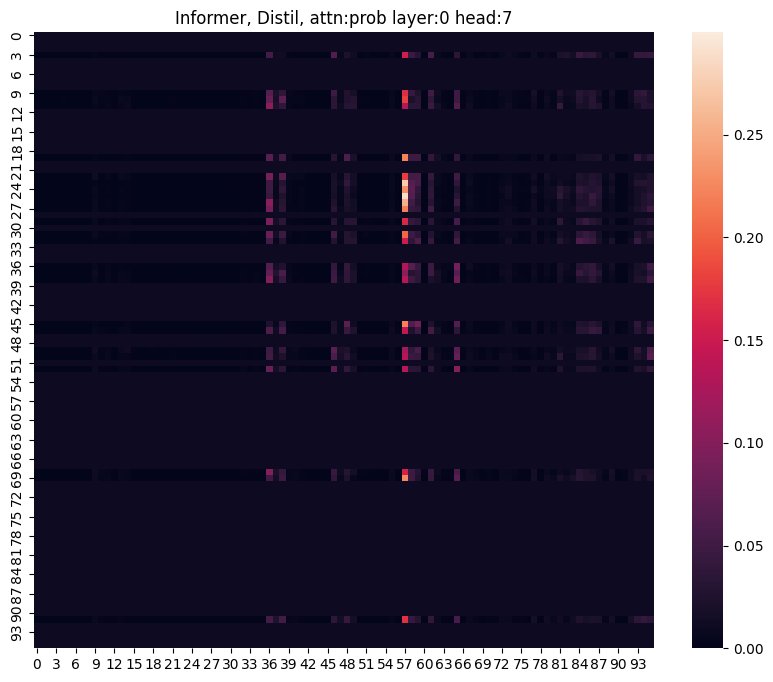

In [105]:
layer = 0
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0,8):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

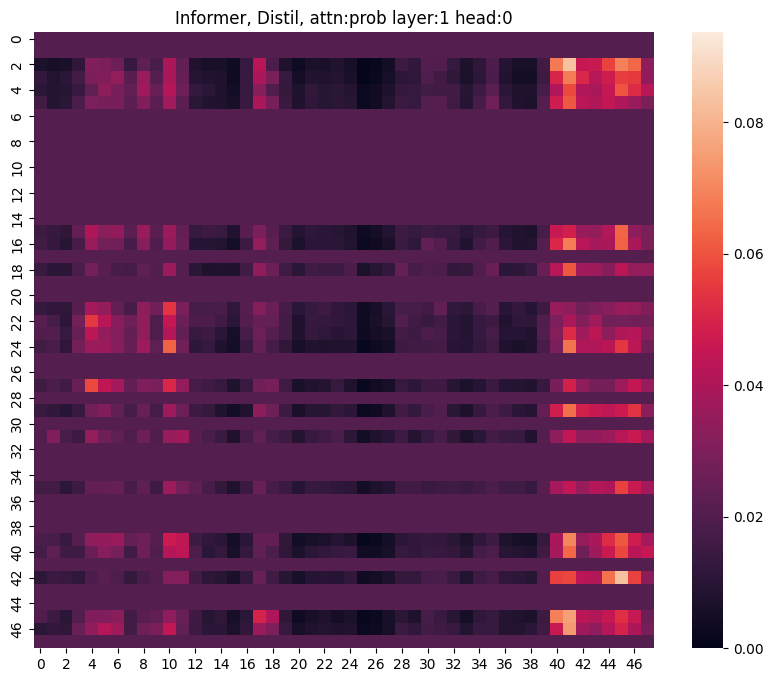

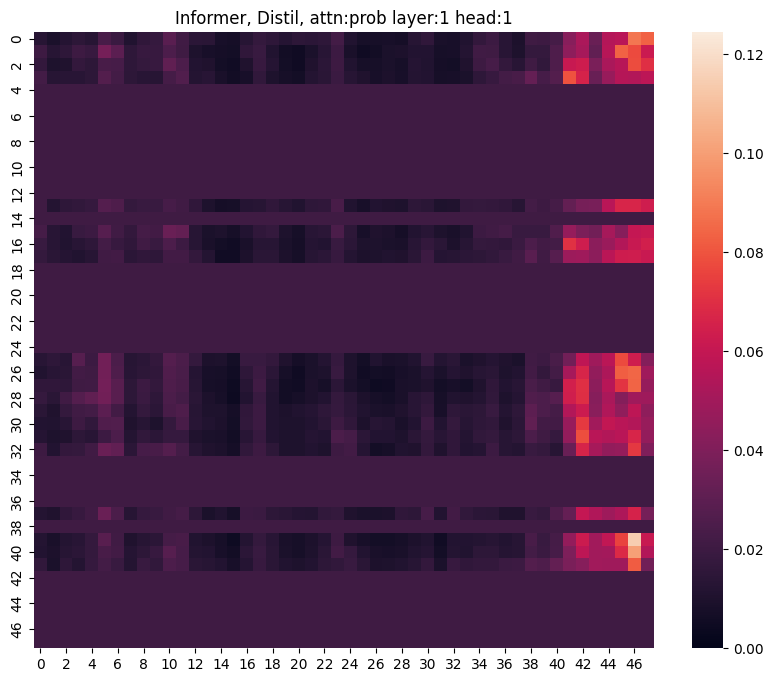

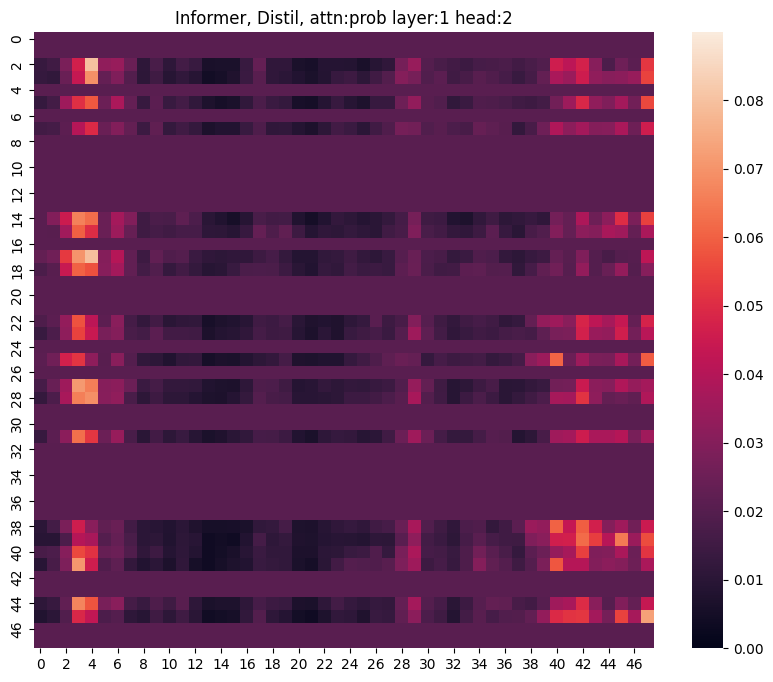

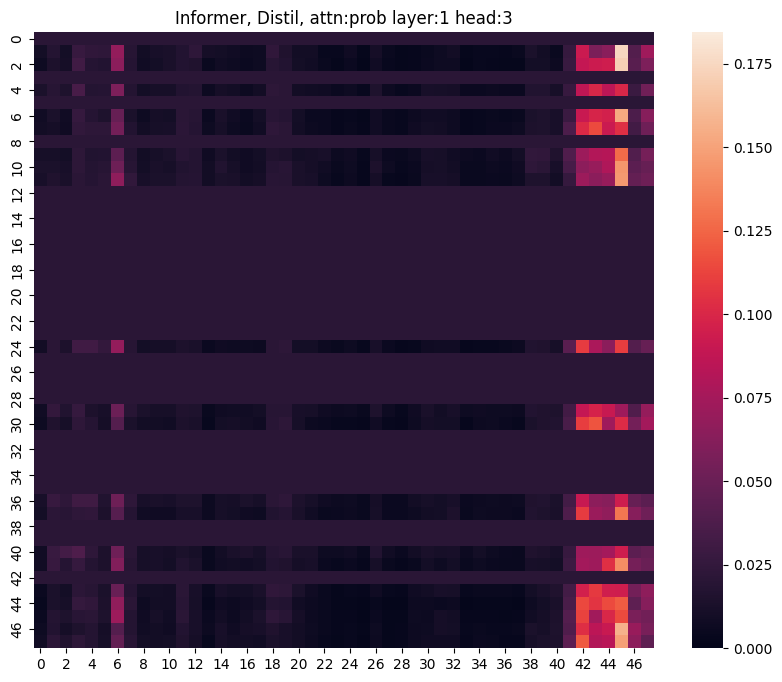

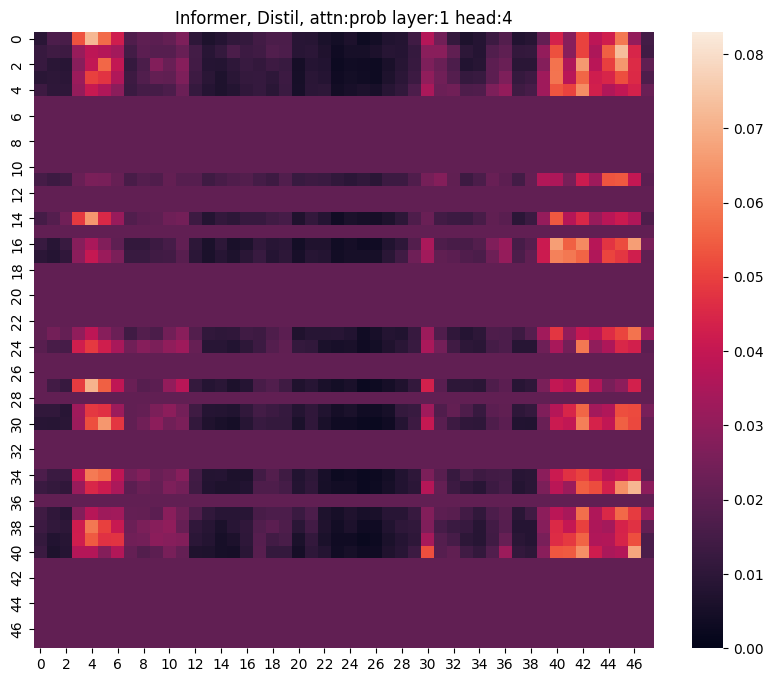

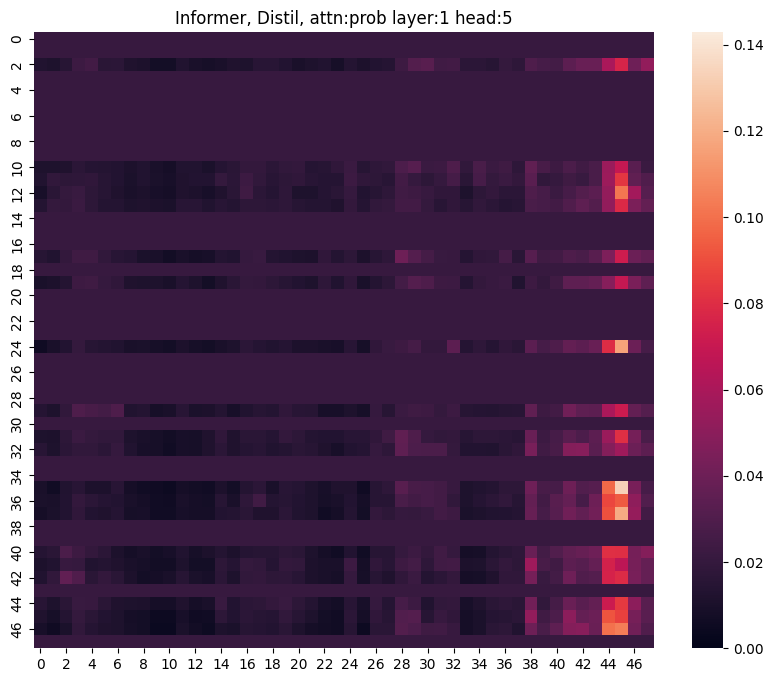

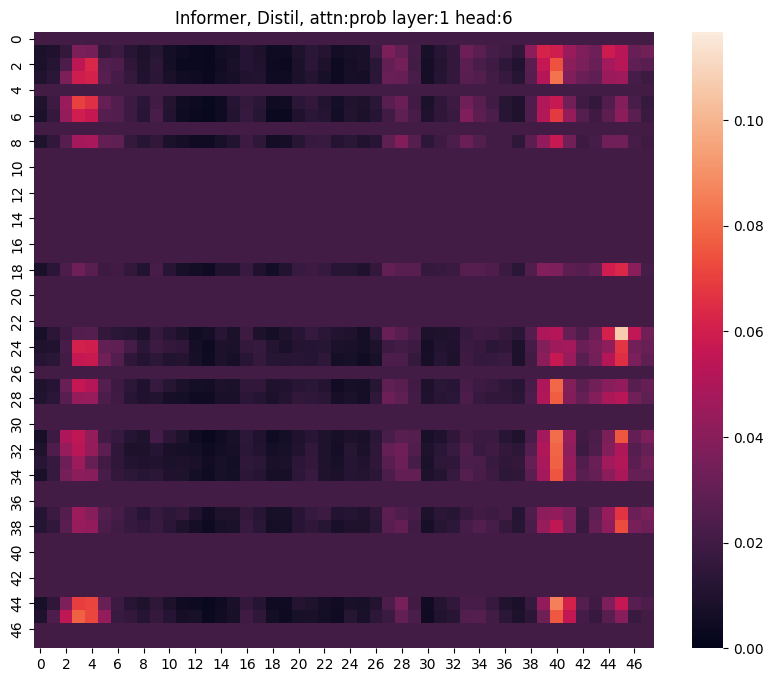

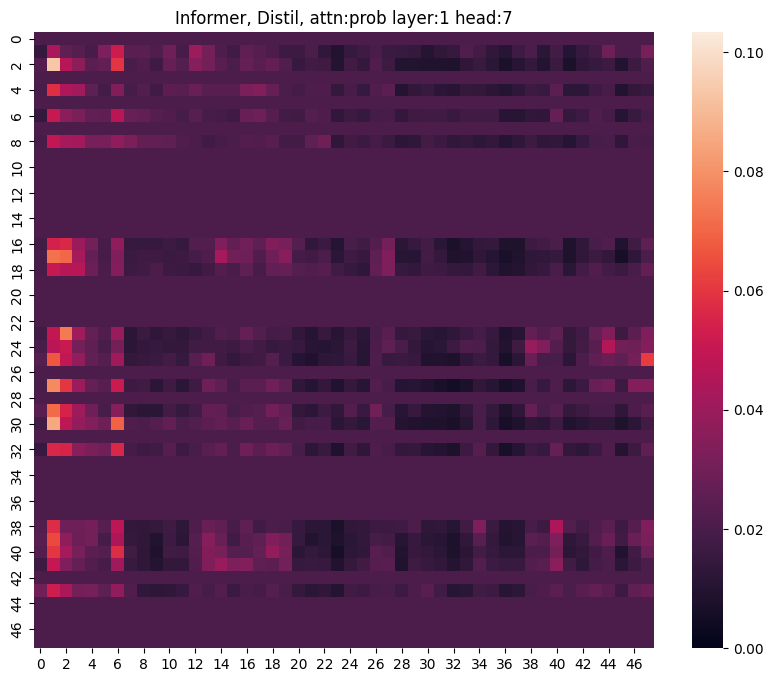

In [106]:
layer = 1
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0,8):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

## Custom Data

Custom data (xxx.csv) has to include at least 2 features: `date`(format: `YYYY-MM-DD hh:mm:ss`) and `target feature`.


In [107]:
from data.data_loader import Dataset_Custom
from torch.utils.data import DataLoader
import pandas as pd
import os

In [ ]:
# custom data: xxx.csv
# data features: ['date', ...(other features), target feature]

# we take ETTh2 as an example
args.root_path = './/'
args.data_path = 'sp500.csv'

df = pd.read_csv(os.path.join(args.root_path, args.data_path))

In [ ]:
df.head()

,date,Open,High,Low,Volume,Close
0,3/1/2000,1469.250000,1478.000000,1438.359985,931800000,1455.219971
1,4/1/2000,1455.219971,1455.219971,1397.430054,1009000000,1399.420044
2,5/1/2000,1399.420044,1413.270020,1377.680054,1085500000,1402.109985
3,6/1/2000,1402.109985,1411.900024,1392.099976,1092300000,1403.449951
4,7/1/2000,1403.449951,1441.469971,1400.729980,1225200000,1441.469971


import altair as alt
from google.colab import autoviz
df_3393190831501063809 = autoviz.get_registered_df('df_3393190831501063809')

def histogram(df, colname, maxbins=20, width=100, height=50):
  return (alt.Chart(df).mark_bar()
          .encode(
              x=alt.X(colname, bin=alt.Bin(maxbins=maxbins)),
              y=alt.Y('count()', axis=alt.Axis(title='count')),
          )
          .properties(width=width, height=height))  #  Pixels.

chart = histogram(df_3393190831501063809, *['index'], **{})
chart

import altair as alt
from google.colab import autoviz
df_2501264830746612788 = autoviz.get_registered_df('df_2501264830746612788')

def histogram(df, colname, maxbins=20, width=100, height=50):
  return (alt.Chart(df).mark_bar()
          .encode(
              x=alt.X(colname, bin=alt.Bin(maxbins=maxbins)),
              y=alt.Y('count()', axis=alt.Axis(title='count')),
          )
          .properties(width=width, height=height))  #  Pixels.

chart = histogram(df_2501264830746612788, *['Open'], **{})
chart

import altair as alt
from google.colab import autoviz
df_8861772690944967662 = autoviz.get_registered_df('df_8861772690944967662')

def histogram(df, colname, maxbins=20, width=100, height=50):
  return (alt.Chart(df).mark_bar()
          .encode(
              x=alt.X(colname, bin=alt.Bin(maxbins=maxbins)),
              y=alt.Y('count()', axis=alt.Axis(title='count')),
          )
          .properties(width=width, height=height))  #  Pixels.

chart = histogram(df_8861772690944967662, *['High'], **{})
chart

import altair as alt
from google.colab import autoviz
df_7497133957438680969 = autoviz.get_registered_df('df_7497133957438680969')

def histogram(df, colname, maxbins=20, width=100, height=50):
  return (alt.Chart(df).mark_bar()
          .encode(
              x=alt.X(colname, bin=alt.Bin(maxbins=maxbins)),
              y=alt.Y('count()', axis=alt.Axis(title='count')),
          )
          .properties(width=width, height=height))  #  Pixels.

chart = histogram(df_7497133957438680969, *['Low'], **{})
chart

import altair as alt
from google.colab import autoviz
df_2156838635096348190 = autoviz.get_registered_df('df_2156838635096348190')

def value_plot(df, y, sort_ascending=False, width=100, height=50):
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  return (alt.Chart(df.reset_index()).mark_line()
          .encode(x=alt.X('index', title=''), y=alt.X(y, title='value'))
          .properties(width=width, height=height, title=y))

chart = value_plot(df_2156838635096348190, *['index'], **{})
chart

import altair as alt
from google.colab import autoviz
df_4611247059065357735 = autoviz.get_registered_df('df_4611247059065357735')

def value_plot(df, y, sort_ascending=False, width=100, height=50):
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  return (alt.Chart(df.reset_index()).mark_line()
          .encode(x=alt.X('index', title=''), y=alt.X(y, title='value'))
          .properties(width=width, height=height, title=y))

chart = value_plot(df_4611247059065357735, *['Open'], **{})
chart

import altair as alt
from google.colab import autoviz
df_2864263803013212737 = autoviz.get_registered_df('df_2864263803013212737')

def value_plot(df, y, sort_ascending=False, width=100, height=50):
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  return (alt.Chart(df.reset_index()).mark_line()
          .encode(x=alt.X('index', title=''), y=alt.X(y, title='value'))
          .properties(width=width, height=height, title=y))

chart = value_plot(df_2864263803013212737, *['High'], **{})
chart

import altair as alt
from google.colab import autoviz
df_6623840557091865805 = autoviz.get_registered_df('df_6623840557091865805')

def value_plot(df, y, sort_ascending=False, width=100, height=50):
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  return (alt.Chart(df.reset_index()).mark_line()
          .encode(x=alt.X('index', title=''), y=alt.X(y, title='value'))
          .properties(width=width, height=height, title=y))

chart = value_plot(df_6623840557091865805, *['Low'], **{})
chart

import altair as alt
from google.colab import autoviz
df_5977344984889145392 = autoviz.get_registered_df('df_5977344984889145392')

def categorical_histogram(df, colname, width=100, height=50, colormap='dark2'):
  chart_data = df[colname].value_counts().reset_index(name='count')
  return (alt.Chart(chart_data).mark_bar()
          .encode(
              x='count', y=alt.Y('index', title=''),
              color=alt.Color(
                  'index', scale=alt.Scale(scheme=colormap), legend=None))
          .properties(width=width, height=height, title=colname))  # Pixels.

chart = categorical_histogram(df_5977344984889145392, *['date'], **{})
chart

import altair as alt
from google.colab import autoviz
df_3489212505896458570 = autoviz.get_registered_df('df_3489212505896458570')

def linked_scatter_plots(
    df, colname_pairs, color='steelblue', deselected_color='lightgray',
    opacity=0.8, deselected_opacity=0.4, width=150, height=150):
  interval = alt.selection_interval()
  scatter = (alt.Chart(df).mark_circle()
             .encode(
                 color=alt.condition(
                     interval, alt.value(color), alt.value(deselected_color)),
                 opacity=alt.condition(
                     interval, alt.value(opacity),
                     alt.value(deselected_opacity)))
             .properties(
                 selection=interval, width=width, height=height))
  return alt.hconcat(*[scatter.encode(x=x, y=y) for x, y in colname_pairs])

chart = linked_scatter_plots(df_3489212505896458570, *[[['index', 'Open'], ['Open', 'High'], ['High', 'Low'], ['Low', 'Volume']]], **{})
chart

import altair as alt
from google.colab import autoviz
df_4789267583275704859 = autoviz.get_registered_df('df_4789267583275704859')

def swarm_plot(df, value_colname, facet_colname, height=150, width=150):
  value_min, value_max = df[value_colname].min(), df[value_colname].max()
  num_facets = len(df[facet_colname].unique())
  value_colname += ':Q'
  facet_colname += ':N'
  return (alt.Chart(df).mark_circle(size=8)
          .encode(
              x=alt.X('jitter:Q', title=None,
                      axis=alt.Axis(
                          values=[0], ticks=True, grid=False, labels=False)),
              y=alt.Y(value_colname,
                      scale=alt.Scale(domain=[value_min, value_max])),
              color=alt.Color(facet_colname, legend=None),
              column=alt.Column(
                  facet_colname,
                  header=alt.Header(
                      labelAngle=-90, titleOrient='top', labelOrient='bottom',
                      labelAlign='right', labelPadding=3)))
          .properties(height=height, width=width / num_facets)
          .transform_calculate(
              jitter='sqrt(-2*log(random()))*cos(2*PI*random())')  # Box-Muller.
          .configure_facet(spacing=0)
          .configure_view(stroke=None))

chart = swarm_plot(df_4789267583275704859, *['index', 'date'], **{})
chart

import altair as alt
from google.colab import autoviz
df_2255084715843412367 = autoviz.get_registered_df('df_2255084715843412367')

def swarm_plot(df, value_colname, facet_colname, height=150, width=150):
  value_min, value_max = df[value_colname].min(), df[value_colname].max()
  num_facets = len(df[facet_colname].unique())
  value_colname += ':Q'
  facet_colname += ':N'
  return (alt.Chart(df).mark_circle(size=8)
          .encode(
              x=alt.X('jitter:Q', title=None,
                      axis=alt.Axis(
                          values=[0], ticks=True, grid=False, labels=False)),
              y=alt.Y(value_colname,
                      scale=alt.Scale(domain=[value_min, value_max])),
              color=alt.Color(facet_colname, legend=None),
              column=alt.Column(
                  facet_colname,
                  header=alt.Header(
                      labelAngle=-90, titleOrient='top', labelOrient='bottom',
                      labelAlign='right', labelPadding=3)))
          .properties(height=height, width=width / num_facets)
          .transform_calculate(
              jitter='sqrt(-2*log(random()))*cos(2*PI*random())')  # Box-Muller.
          .configure_facet(spacing=0)
          .configure_view(stroke=None))

chart = swarm_plot(df_2255084715843412367, *['Open', 'date'], **{})
chart

import altair as alt
from google.colab import autoviz
df_4673854350378846867 = autoviz.get_registered_df('df_4673854350378846867')

def swarm_plot(df, value_colname, facet_colname, height=150, width=150):
  value_min, value_max = df[value_colname].min(), df[value_colname].max()
  num_facets = len(df[facet_colname].unique())
  value_colname += ':Q'
  facet_colname += ':N'
  return (alt.Chart(df).mark_circle(size=8)
          .encode(
              x=alt.X('jitter:Q', title=None,
                      axis=alt.Axis(
                          values=[0], ticks=True, grid=False, labels=False)),
              y=alt.Y(value_colname,
                      scale=alt.Scale(domain=[value_min, value_max])),
              color=alt.Color(facet_colname, legend=None),
              column=alt.Column(
                  facet_colname,
                  header=alt.Header(
                      labelAngle=-90, titleOrient='top', labelOrient='bottom',
                      labelAlign='right', labelPadding=3)))
          .properties(height=height, width=width / num_facets)
          .transform_calculate(
              jitter='sqrt(-2*log(random()))*cos(2*PI*random())')  # Box-Muller.
          .configure_facet(spacing=0)
          .configure_view(stroke=None))

chart = swarm_plot(df_4673854350378846867, *['High', 'date'], **{})
chart

import altair as alt
from google.colab import autoviz
df_4676205245792546916 = autoviz.get_registered_df('df_4676205245792546916')

def swarm_plot(df, value_colname, facet_colname, height=150, width=150):
  value_min, value_max = df[value_colname].min(), df[value_colname].max()
  num_facets = len(df[facet_colname].unique())
  value_colname += ':Q'
  facet_colname += ':N'
  return (alt.Chart(df).mark_circle(size=8)
          .encode(
              x=alt.X('jitter:Q', title=None,
                      axis=alt.Axis(
                          values=[0], ticks=True, grid=False, labels=False)),
              y=alt.Y(value_colname,
                      scale=alt.Scale(domain=[value_min, value_max])),
              color=alt.Color(facet_colname, legend=None),
              column=alt.Column(
                  facet_colname,
                  header=alt.Header(
                      labelAngle=-90, titleOrient='top', labelOrient='bottom',
                      labelAlign='right', labelPadding=3)))
          .properties(height=height, width=width / num_facets)
          .transform_calculate(
              jitter='sqrt(-2*log(random()))*cos(2*PI*random())')  # Box-Muller.
          .configure_facet(spacing=0)
          .configure_view(stroke=None))

chart = swarm_plot(df_4676205245792546916, *['Low', 'date'], **{})
chart

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
'''
We set 'HULL' as target instead of 'OT'

The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
'''

args.target = 'HULL'
args.freq = 'h'

Data = Dataset_Custom
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'; shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    target=args.target, # HULL here
    freq=args.freq # 'h': hourly, 't':minutely
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

ValueError: ignored

In [ ]:
batch_x,batch_y,batch_x_mark,batch_y_mark = data_set[0]